## Notes: 
- Extremely Overfit
- Needs to be tuned 
- Maybe alter the cnn or mlp

Also will only run on colab because the training loop moves memory over to the gpu

In [1]:
!pip install pandas

!pip install d2l==0.17.6
#!pip install matplotlib
!pip install matplotlib-inline

!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import cv2
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [5]:
!git clone -b @olly-branch "https://github.com/BSteiner1/ST311-Group-Project/"

fatal: destination path 'ST311-Group-Project' already exists and is not an empty directory.


### Data Loading (Spectograms)
- Collect our spectogram images

In [6]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

In [7]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("ST311-Group-Project/Data/images_original"):
        for image in os.listdir("ST311-Group-Project/Data/images_original/" + genre):
            image_path = "ST311-Group-Project/Data/images_original/" + genre + "/" + image
            # Convert to grayscale
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Trim the excess white pixels from the image
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            # Convert to tensor
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  
            data.append((grayscale_img.reshape(1,217,335), torch.tensor(class_dict.get(genre))))

    return data         


In [8]:
data = collect_data()

In [9]:
# Split our data into train and test sets with an 80:20 split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [10]:
# Convert to data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

### Data Loading (Features)

In [11]:
feature_path = "ST311-Group-Project/Data/features_30_sec - edited.csv"

In [12]:
# Load in the metadata into a DataFrame
raw_df = pd.read_csv(feature_path)
raw_df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.0645,2002.449060,85882.76132,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.0736,2039.036516,213843.75550,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.6434,1747.702312,76254.19226,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.9424,1596.412872,166441.49480,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.9393,1748.172116,88445.20904,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [13]:
# Remove unnecessary variables for prediction
del raw_df['filename']
del raw_df['length']
# Map the label to a number
raw_df['label'] = raw_df['label'].map(class_dict)

In [14]:
# Scale each column of the DataFrame to mean 0 variance 1
df = StandardScaler().fit_transform(raw_df.iloc[:, 0:-1])
df = pd.DataFrame(df, columns = raw_df.columns.tolist()[:-1])
df['label'] = raw_df['label']

In [15]:
# Colect the (metadata, label) tuples and convert to tensors
metadata = [(torch.tensor(list(df.loc[i][:-1])).clone().detach().requires_grad_(True).reshape(1,1,-1), \
             torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

In [16]:
# 80:20 train-test split for our metadata
meta_train_size = int(0.80 * len(metadata))
meta_test_size = len(metadata) - meta_train_size
metadata_train_dataset, metadata_test_dataset = torch.utils.data.random_split(metadata, [meta_train_size, meta_test_size])

In [17]:
# Add to data loaders
metadata_train_loader = DataLoader(metadata_train_dataset, batch_size=40, shuffle=True)
metadata_test_loader = DataLoader(metadata_test_dataset, batch_size=20, shuffle=False)

### Train CNN 

In [61]:
'''
Parameters
'''
# Define our hyperparameter values
cnn_epochs = 50
cnn_lr = 0.01
cnn_batch_size = 30

'''
Net

'''

cnn_net = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size=3, stride=3),

    nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size=3, stride=3),

    nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size=3, stride=3),

    nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size = 3, stride = 3),

    nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.Flatten(),

    nn.Linear(512, 64), nn.Dropout(0.2), nn.ReLU(),

    nn.Linear(64,10)

)

loss 0.030, train acc 0.996, test acc 0.590
1099.0 examples/sec on cuda:0


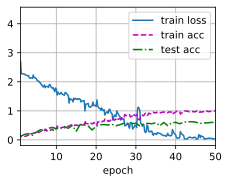

In [62]:
d2l.train_ch6(cnn_net, train_loader, test_loader, cnn_epochs, cnn_lr, d2l.try_gpu())

### MLP Training

In [96]:
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(57, 32), nn.ReLU(), nn.Dropout(0.25),
    nn.Linear(32, 16), nn.ReLU(), nn.Dropout(0.25),
    nn.Linear(16, 10)
)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(mlp_model.parameters(), lr=0.1)
meta_epochs = 50

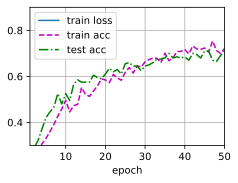

In [97]:
d2l.train_ch3(mlp_model, metadata_train_loader, metadata_test_loader, loss, meta_epochs, trainer)

# Done up to here

### Ensemble (Test Acc. 67)

Data Loading:

In [ ]:
joined_data = [(data[i][0], metadata[i][0], torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

In [ ]:
joined_data[0]

(tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [ 21., 110.,  73.,  ..., 134., 123.,  80.],
          [ 21., 110.,  73.,  ..., 134., 123.,  80.],
          [ 10.,  24.,   0.,  ...,   0.,   0.,  26.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([[[-0.3515,  0.3121, -0.0102, -0.0619, -0.5842, -0.8485, -0.4564,
           -0.5303, -0.4871, -0.6615, -0.4929, -0.7350,  0.1905, -0.3740,
            0.3719,  0.0037,  0.1269,  0.3087, -0.4281,  0.7036, -0.9358,
           -0.4722, -0.8114,  0.3637, -0.5974, -0.4268, -0.0651,  0.3363,
           -0.5567, -0.8625, -0.8357,  0.4987, -0.4703, -0.6369, -0.1614,
            0.4086, -0.5006, -0.3379, -0.3617,  0.6445, -0.5346,  0.1822,
           -0.8044,  0.7917, -0.7032, -0.2647, -0.3865, -0.0868, -0.2465,
            0.4999, -0.7801, -0.2375, -0.6429,  0.0066, -0.3008,  0.6037,
           -0.5122]]], gr

In [ ]:
joined_train_size = int(0.8 * len(joined_data))
joined_test_size = len(joined_data) - joined_train_size
joined_train_dataset, joined_test_dataset = torch.utils.data.random_split(joined_data, [joined_train_size, joined_test_size])

In [ ]:
joined_train_loader = DataLoader(joined_train_dataset, batch_size=16, shuffle=True)
joined_test_loader = DataLoader(joined_test_dataset, batch_size=10, shuffle=False)

Net

In [ ]:
class cnn_mlp(nn.Module):
    def __init__(self):
        super(cnn_mlp, self).__init__()

        #Net to process images
        self.net3 = net3

        #Net to process features
        self.model = model

        self.fc1 = nn.Linear(20, 16)
        self.sig = nn.Sigmoid()
        self.fc2 = nn.Linear(16,10)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x1, x2):

        #Pass image through first subnetwork
        out1 = self.net3(x1)

        out1.size()

        #Pass features through second subnetwork
        out2 = self.model(x2)

        out2.size()

        #Concatenate
        out = torch.cat((out1, out2), dim = 1)

        out.size()
        
        #Pass through linear layer
        x = self.fc1(out)
        x = self.dropout(x)
        x = self.sig(x)
        x = self.fc2(x)

        return x

Training

In [ ]:
# Define instance of ensemble

#to.('cuda') ensures loop runs on colab gpu

cnn_mlp = cnn_mlp().to('cuda')

In [ ]:
#Define Loss and optimiser

cnn_mlp_optimizer = torch.optim.Adam(cnn_mlp.parameters(), lr=0.001)
cnn_mlp_loss = nn.CrossEntropyLoss()

In [ ]:
#Define Epochs

cnn_mlp_epochs = 200

In [ ]:
#Main Loop

for epoch in range(cnn_mlp_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs1, inputs2, targets) in enumerate(joined_train_loader):
      
        #Moves inputs to the gpu
        inputs1 = inputs1.to('cuda')
        inputs2 = inputs2.to('cuda')
        targets = targets.to('cuda')

        # Zero the gradients
        cnn_mlp_optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_mlp(inputs1, inputs2)
        loss = cnn_mlp_loss(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        cnn_mlp_optimizer.step()
        
        # Compute running loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Compute validation loss and accuracy
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs1, inputs2, targets in joined_test_loader:

            #Moves inputs to gpu
            inputs1 = inputs1.to('cuda')
            inputs2 = inputs2.to('cuda')
            targets = targets.to('cuda')
            
            outputs = cnn_mlp(inputs1, inputs2)
            loss = cnn_mlp_loss(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    

    # Print epoch statistics
    print('Epoch %d: Train Loss: %.3f | Train Acc: %.3f%% | Val Loss: %.3f | Val Acc: %.3f%%'
          % (epoch+1, running_loss/len(joined_train_loader), 100*correct/total,
             val_loss/len(joined_test_loader), 100*val_correct/val_total))

Epoch 1: Train Loss: 2.241 | Train Acc: 13.016% | Val Loss: 2.175 | Val Acc: 21.000%
Epoch 2: Train Loss: 2.117 | Train Acc: 32.791% | Val Loss: 2.105 | Val Acc: 32.500%
Epoch 3: Train Loss: 2.035 | Train Acc: 46.683% | Val Loss: 1.999 | Val Acc: 49.500%
Epoch 4: Train Loss: 1.942 | Train Acc: 57.572% | Val Loss: 1.957 | Val Acc: 57.500%
Epoch 5: Train Loss: 1.885 | Train Acc: 63.705% | Val Loss: 1.876 | Val Acc: 59.500%
Epoch 6: Train Loss: 1.810 | Train Acc: 68.085% | Val Loss: 1.852 | Val Acc: 62.500%
Epoch 7: Train Loss: 1.748 | Train Acc: 73.467% | Val Loss: 1.792 | Val Acc: 63.000%
Epoch 8: Train Loss: 1.692 | Train Acc: 77.222% | Val Loss: 1.751 | Val Acc: 65.000%
Epoch 9: Train Loss: 1.639 | Train Acc: 78.723% | Val Loss: 1.705 | Val Acc: 69.500%
Epoch 10: Train Loss: 1.586 | Train Acc: 80.350% | Val Loss: 1.683 | Val Acc: 72.500%
Epoch 11: Train Loss: 1.540 | Train Acc: 80.476% | Val Loss: 1.631 | Val Acc: 71.500%
Epoch 12: Train Loss: 1.507 | Train Acc: 80.851% | Val Loss: 1.

KeyboardInterrupt: ignored

### ??????^